# Lottery Hypothesis: MNIST [300 100] classification

In [1]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.datasets import mnist
from tensorflow_model_optimization.sparsity import keras as sparsity

In [2]:
batch_size = 128
num_classes = 10
epochs = 50

In [3]:
# Data preprocessing and cleadning:
# input image dimensions
img_rows, img_cols = 28, 28

In [4]:
# Download the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [5]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print("\n'input_shape' which will be used = {0}\n".format(input_shape))


'input_shape' which will be used = (28, 28, 1)



### Data preprocessing:

In [6]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [7]:
# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

In [8]:
# convert class vectors/target to binary class matrices or one-hot encoded values-
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [9]:
# Reshape training and testing sets-
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

In [10]:
print("\nDimensions of training and testing sets are:")
print("X_train.shape = {0}, y_train = {1}".format(X_train.shape, y_train.shape))
print("X_test.shape = {0}, y_test = {1}".format(X_test.shape, y_test.shape))


Dimensions of training and testing sets are:
X_train.shape = (60000, 784), y_train = (60000, 10)
X_test.shape = (10000, 784), y_test = (10000, 10)


### Define Neural Network to be used for training:

In [11]:
# Compute 'end_step' parameter needed for pruning-
num_train_samples = X_train.shape[0]
end_step = np.ceil(1.0 * num_train_samples / batch_size).astype(np.int32) * epochs
print("\n'end_step' = {0}\n".format(end_step))


'end_step' = 23450



In [12]:
# Parameters to be used for pruning neural network-
pruning_params = {
    'pruning_schedule': sparsity.PolynomialDecay(
        initial_sparsity = 0.0, final_sparsity = 0.70,
        begin_step = 2000, end_step = end_step,
        frequency=100)
}

In [13]:
# Parameters to be used for NOT pruning neural network-
pruning_params_unpruned = {
    'pruning_schedule': sparsity.PolynomialDecay(
        initial_sparsity = 0.0, final_sparsity = 0.0,
        begin_step = 2000, end_step = end_step,
        frequency=100)
}

In [14]:
def create_nn_pruning(pruning_params):
    """
    Function to define a 300 100 dense
    fully connected architecture for MNIST
    classification
    """
    pruned_model = Sequential()
    
    pruned_model.add(
        sparsity.prune_low_magnitude(
            Dense(units = 300, activation = 'relu',
                  kernel_initializer = tf.keras.initializers.GlorotUniform,
                  input_shape = (784,)
                 ), 
            **pruning_params)
    )

    pruned_model.add(
        sparsity.prune_low_magnitude(
            Dense(
                units = 100, activation = 'relu',
                kernel_initializer = tf.keras.initializers.GlorotUniform
            ),
            **pruning_params))
    
    pruned_model.add(
        sparsity.prune_low_magnitude(
            Dense(
                units = 10, activation = 'softmax'
            ),
            **pruning_params))
    
    # Compile defined model-
    pruned_model.compile(
        loss = tf.keras.losses.categorical_crossentropy,
        optimizer=tf.keras.optimizers.Adam(lr = 0.001),
        metrics = ['accuracy'])

    return pruned_model



# _One Shot_ pruning approach: Lottery Ticket Hypothesis

### Step - 1: Randomly initialize a neural network
Randomly initialize the weights of the defined neural network WITHOUT pruning

In [15]:
# Instantiate 
orig_model = create_nn_pruning(pruning_params_unpruned)

W0121 14:18:00.570797 139866708326208 deprecation.py:323] From /home/arjun/.local/lib/python3.7/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:185: Layer.add_variable (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.add_weight` method instead.
W0121 14:18:00.871846 139866708326208 deprecation.py:323] From /home/arjun/.local/lib/python3.7/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_schedule.py:240: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [16]:
# Save weights of randomly initialized, untrained, unpruned model with pruning parameters-
orig_model.save_weights("Weights_Resources/MNIST_300_100_Randomly_Initialized_with_pruning_params.h5",
                       overwrite=True)

### Early Stopping:
Early stopping is a technique used to terminate the training before overfitting occurs.

1. _monitor_ keeps track of the quantity that is used to decide if the training should be terminated. In this case, we use the validation loss.

1. _min_delta_ is the threshold that triggers the termination. In this case, we require that the loss should at least improve by 0.0001.

1. _patience_ is the number of "no improvement epochs" to wait until training is stopped. With patience = 3, training terminates immediately after the first three epochs with no improvement.


__Summary:__

The key takeaway is to use the _tf.keras.EarlyStopping_ callback. Early stopping is triggered by monitoring if a certain value (for example, validation accuracy) has improved over the latest period of time (controlled by the patience argument).



https://lambdalabs.com/blog/tensorflow-2-0-tutorial-04-early-stopping/

In [17]:
# Add a pruning step callback to peg the pruning step to the optimizer's
# step. Also add a callback to add pruning summaries to tensorboard
callbacks = [
    sparsity.UpdatePruningStep(),
    # sparsity.PruningSummaries(log_dir=logdir, profile_batch=0)
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,
                                    min_delta=0.0001)
]


### Step - 2: Train the (defined) network for _j_ iterations, arriving at parameters _theta_j_:

In [18]:
# Train original unpruned model-
history_orig = orig_model.fit(
    x = X_train, y = y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=0,
    callbacks=callbacks,
    validation_data=(X_test, y_test))


In [19]:
history_orig.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

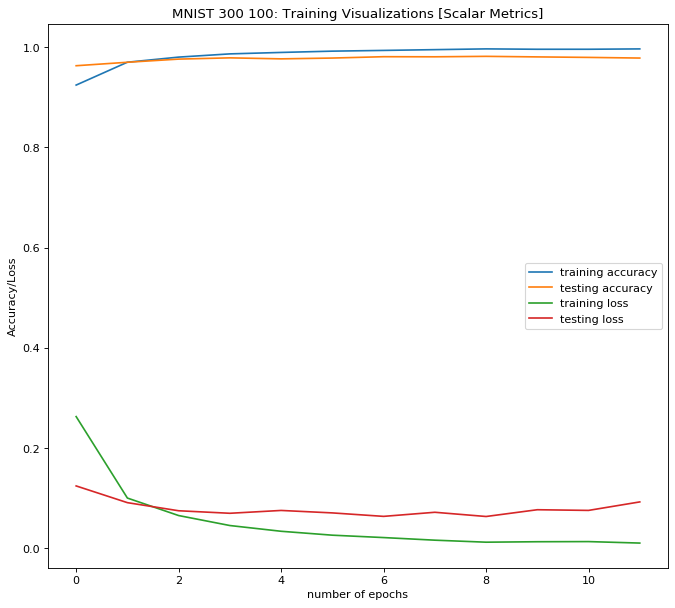

In [26]:
# Visualize training - [Scalar metrics]:

fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(history_orig.history['accuracy'], label = 'training accuracy')
plt.plot(history_orig.history['val_accuracy'], label = 'testing accuracy')
plt.plot(history_orig.history['loss'], label = 'training loss')
plt.plot(history_orig.history['val_loss'], label = 'testing loss')

plt.title("MNIST 300 100: Training Visualizations [Scalar Metrics]")
plt.xlabel("number of epochs")
plt.ylabel("Accuracy/Loss")
plt.legend(loc = 'best')
plt.show()

In [20]:
# Save trained unpruned model with pruning parameters-
orig_model.save_weights("Weights_Resources/MNIST_300_100_Trained_with_pruning_params.h5",
                       overwrite=True)

### Step - 3: Prune _p%_ of the parameters in _theta_j_ (from step - 2), creating a mask _m_

The mask is created as follows-
1. Weights surviving the pruning are initialized to one (1)
1. Weights which are pruned are initialized to zero (0)

In [21]:
# Instantiate a network which loads weights of already trained model for pruning-
pruned_model = create_nn_pruning(pruning_params)

In [22]:
# Load weights of already trained model which is to be pruned-
pruned_model.load_weights("Weights_Resources/MNIST_300_100_Trained_with_pruning_params.h5")

In [23]:
history_pruned = pruned_model.fit(
    x = X_train, y = y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=0,
    callbacks=callbacks,
    validation_data=(X_test, y_test))


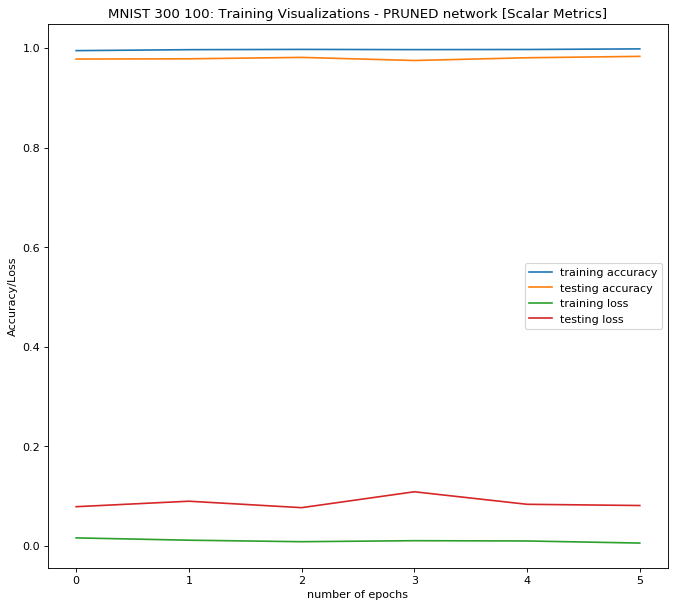

In [24]:
# Visualize training - [Scalar metrics]:

fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(history_pruned.history['accuracy'], label = 'training accuracy')
plt.plot(history_pruned.history['val_accuracy'], label = 'testing accuracy')
plt.plot(history_pruned.history['loss'], label = 'training loss')
plt.plot(history_pruned.history['val_loss'], label = 'testing loss')

plt.title("MNIST 300 100: Training Visualizations - PRUNED network [Scalar Metrics]")
plt.xlabel("number of epochs")
plt.ylabel("Accuracy/Loss")
plt.legend(loc = 'best')
plt.show()

In [48]:
# Evaluate pruned trained model on testing dataset-
score = pruned_model.evaluate(X_test, y_test, verbose=0)

print("\nPruned model metrics:")
print("Testing dataset loss = {0:.4f} and accuracy = {1:.4f}\n".format(score[0], score[1]))


Pruned model metrics:
Testing dataset loss = 0.0807 and accuracy = 0.9832



In [49]:
# Evaluate original unpruned model on testing dataset-
score_orig = orig_model.evaluate(X_test, y_test, verbose=0)

print("\nOriginal Unpruned model metrics:")
print("Testing dataset loss = {0:.4f} and accuracy = {1:.4f}\n".format(score_orig[0], score_orig[1]))


Original Unpruned model metrics:
Testing dataset loss = 0.0804 and accuracy = 0.9776



In [25]:
# Save trained pruned model with pruning parameters-
pruned_model.save_weights("Weights_Resources/MNIST_300_100_Trained_Pruned_with_pruning_params.h5",
                       overwrite=True)

In [35]:
# Strip pruning network of the pruning parameters-
pruned_model_stripped = sparsity.strip_pruning(pruned_model)

In [36]:
# Strip original network of the pruning parameters-
orig_model_stripped = sparsity.strip_pruning(orig_model)

In [37]:
print("\nNumber of non-zero trainable parameters in Original Unpruned Model:\n")

orig_model_sum_params = 0

for layer in orig_model_stripped.trainable_weights:
    print(tf.math.count_nonzero(layer, axis = None).numpy())
    orig_model_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()

print("\nTotal number of non-zero trainable parameters in model: {0}\n".format(orig_model_sum_params))


Number of non-zero trainable parameters in Original Unpruned Model:

235200
300
30000
100
1000
10

Total number of non-zero trainable parameters in model: 266610



In [ ]:
orig_model.summary()

In [38]:
print("\nNumber of non-zero trainable parameters in Pruned Model:\n")

pruned_model_sum_params = 0

for layer in pruned_model_stripped.trainable_weights:
    print(tf.math.count_nonzero(layer, axis = None).numpy())
    pruned_model_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()

print("\nTotal number of non-zero trainable parameters in model: {0}\n".format(pruned_model_sum_params))


Number of non-zero trainable parameters in Pruned Model:

217457
300
27737
100
925
10

Total number of non-zero trainable parameters in model: 246529



In [39]:
print("\n% of connections pruned away = {0:.4f}%\n".format(
    ((orig_model_sum_params - pruned_model_sum_params) / orig_model_sum_params) * 100))


% of connections pruned away = 7.5320%



In [40]:
# Instantiate a new neural network model for which, the mask is to be created,
# according to the paper-
mask_model = create_nn_pruning(pruning_params_unpruned)

In [41]:
# Load weights of PRUNED model-
mask_model.load_weights("Weights_Resources/MNIST_300_100_Trained_Pruned_with_pruning_params.h5")

In [42]:
# Strip the model of its pruning parameters-
mask_model_stripped = sparsity.strip_pruning(mask_model)

### Creating mask:
To create masks, iterate through each layer of defined model and wherever there is a non-zero weight,
use one and for zero weight, leave as it is.

Using _assign_ method of the _Variable_ class in TensorFlow 2.0

In [43]:
# Create mask:
for pruned_layer, orig_layer in zip(mask_model_stripped.trainable_weights,
                                   orig_model_stripped.trainable_weights):
    pruned_layer.assign(tf.cast(tf.where(tf.equal(pruned_layer, 0), 0, 1), dtype = tf.float32))

### Sanity check: See if the mask _m_ is created:

In [44]:
mask_model_stripped.trainable_weights[0].numpy()

array([[1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.]], dtype=float32)

In [47]:
mask_model_stripped.trainable_weights[4].numpy()

array([[1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [1., 1., 0., 0., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
       [1., 1., 1., 0., 1., 1., 1., 1., 0., 1.],
       [1., 1., 0., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1., 0., 0., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
       [1., 1., 1., 0., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0., 1., 1., 1., 1., 0.],
       [1., 1., 1., 

### Step - 4: Reset the remaining parameters to their original values (from Step - 1, _theta_0_), creating the winning ticket

For each layer, for each weight which is 0, leave it, as is. And for weights which survive the pruning,
reinitialize it to the randomly initialized value, the model received BEFORE it was trained and pruned-

In [51]:
# Instantiate a Neural Network model for extraction of winning ticket-
winning_ticket = create_nn_pruning(pruning_params_unpruned)

In [52]:
# Load weights of trained and pruned model with pruning parameters-
winning_ticket.load_weights("Weights_Resources/MNIST_300_100_Trained_Pruned_with_pruning_params.h5")

In [53]:
# Strip model of pruning extra parameters-
winning_ticket_stripped = sparsity.strip_pruning(winning_ticket)

In [54]:
# Extract winning ticket-
for pruned_layer, orig_layer in zip(winning_ticket_stripped.trainable_weights,
                                   orig_model_stripped.trainable_weights):
    pruned_layer.assign(tf.where(tf.equal(pruned_layer, 0.), 0., orig_layer))

### Sanity check: Check whether number of non-zero parameters in _winning_ticket_ & _pruned_model_ are same:

In [55]:
print("\nNumber of non-zero trainable parameters in Winning Ticket Model:\n")

winning_tkt_model_sum_params = 0

for layer in winning_ticket_stripped.trainable_weights:
    print(tf.math.count_nonzero(layer, axis = None).numpy())
    winning_tkt_model_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()

print("\nTotal number of non-zero trainable parameters in model: {0}\n".format(winning_tkt_model_sum_params))


Number of non-zero trainable parameters in Winning Ticket Model:

217457
300
27737
100
925
10

Total number of non-zero trainable parameters in model: 246529



In [58]:
assert (winning_tkt_model_sum_params == pruned_model_sum_params), \
    "Parameters in winning ticket and pruned model do NOT match! Critical Error!"

In [61]:
# Save winning ticket WITHOUT pruning parameters-
winning_ticket_stripped.save_weights("Weights_Resources/MNIST_300_100_Winning_Ticket_without_pruning_params.h5",
                                    overwrite=True)

### Use _GradientTape_ for manual training of neural network:

In [59]:
# Use tf.data to batch and shuffle the dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(100).batch(batch_size)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

In [60]:
#  Choose an optimizer and loss function for training-
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr = 0.001)

In [63]:
def create_nn_gradienttape():
    """
    Function to create neural network for use
    with GradientTape API following MNIST
    300 100 architecture
    """
    model = Sequential()
    
    model.add(
        Dense(
            units = 300, activation = 'relu',
            kernel_initializer = tf.keras.initializers.GlorotNormal,
            input_shape = (784,)
        )
    )
    
    model.add(
        Dense(
            units = 100, activation = 'relu',
            kernel_initializer = tf.keras.initializers.GlorotNormal
        )
    )
    
    model.add(
        Dense(
            units = 10, activation = 'softmax'
        )
    )
    
    return model

In [64]:
# Instantiate the model to be trained using GradientTape-
model = create_nn_gradienttape()

In [65]:
# Load weights from weight extracted model-
model.load_weights("Weights_Resources/MNIST_300_100_Winning_Ticket_without_pruning_params.h5")

In [66]:
# Select metrics to measure the error & accuracy of model.
# These metrics accumulate the values over epochs and then
# print the overall result-
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name = 'train_accuracy')

In [73]:
# Use tf.GradientTape to train the model-

@tf.function
def train_step(data, labels):
    """
    Function to perform one step of Gradient
    Descent optimization
    """

    with tf.GradientTape() as tape:
        # 'training=True' is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        # predictions = model(data, training=True)
        predictions = model(data)
        loss = loss_fn(labels, predictions)

    # 'gradients' is a list variable!
    gradients = tape.gradient(loss, model.trainable_variables)
    
    # IMPORTANT:
    # Multiply mask with computed gradients-
    
    # THIS IS WRONG-
    # gradients = tf.math.multiply(tape.gradient(loss, model.trainable_variables), mask_model_stripped)
    
    # THIS IS CORRECT-
    # List to hold element-wise multiplication between-
    # computed gradient and masks-
    grad_mask_mul = []
    
    # Perform element-wise multiplication between computed gradients and masks-
    for grad_layer, mask in zip(gradients, mask_model_stripped.trainable_weights):
        grad_mask_mul.append(tf.math.multiply(grad_layer, mask))

    # optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    optimizer.apply_gradients(zip(grad_mask_mul, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)


In [68]:
@tf.function
def test_step(data, labels):
    """
    Function to test model performance
    on testing dataset
    """
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(data)
    t_loss = loss_fn(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)


In [69]:
EPOCHS = 15

In [71]:
print("\nOriginal model has = {0} trainable parameters".format(orig_model_sum_params))
print("Pruned model has = {0} has trainable parameters".format(pruned_model_sum_params))


Original model has = 266610 trainable parameters
Pruned model has = 246529 has trainable parameters


In [74]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for x, y in train_ds:
        train_step(x, y)

    for x_t, y_t in test_ds:
        test_step(x_t, y_t)

    template = 'Epoch {0}, Loss: {1:.4f}, Accuracy: {2:.4f}, Test Loss: {3:.4f}, Test Accuracy: {4:4f}'

    print(template.format(epoch + 1, 
                          train_loss.result(), train_accuracy.result()*100,
                          test_loss.result(), test_accuracy.result()*100))
    
    
    # Count number of non-zero parameters in each layer and in total-
    # print("layer-wise manner model, number of nonzero parameters in each layer are: \n")

    model_sum_params = 0
    
    for layer in model.trainable_weights:
        # print(tf.math.count_nonzero(layer, axis = None).numpy())
        model_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()
    
    print("Total number of trainable parameters = {0}\n".format(model_sum_params))



Epoch 1, Loss: 0.0026, Accuracy: 99.9083, Test Loss: 0.0155, Test Accuracy: 99.580994
Total number of trainable parameters = 246529

Epoch 2, Loss: 0.0014, Accuracy: 99.9557, Test Loss: 0.0149, Test Accuracy: 99.618980
Total number of trainable parameters = 246529

Epoch 3, Loss: 0.0021, Accuracy: 99.9244, Test Loss: 0.0150, Test Accuracy: 99.574982
Total number of trainable parameters = 246529

Epoch 4, Loss: 0.0015, Accuracy: 99.9506, Test Loss: 0.0161, Test Accuracy: 99.598984
Total number of trainable parameters = 246529

Epoch 5, Loss: 0.0016, Accuracy: 99.9459, Test Loss: 0.0208, Test Accuracy: 99.502968
Total number of trainable parameters = 246529

Epoch 6, Loss: 0.0011, Accuracy: 99.9614, Test Loss: 0.0138, Test Accuracy: 99.655983
Total number of trainable parameters = 246529

Epoch 7, Loss: 0.0005, Accuracy: 99.9849, Test Loss: 0.0160, Test Accuracy: 99.630989
Total number of trainable parameters = 246529

Epoch 8, Loss: 0.0027, Accuracy: 99.9031, Test Loss: 0.0176, Test Acc

### Sanity check: Check whether the number of trainable parameters DO NOT increase while training using _GradientTape_ API:

In [75]:
print("\nNumber of non-zero trainable parameters in Winning Ticket Model (Gradient Tape using masks):\n")

winning_tkt_model_sum_params2 = 0

for layer in model.trainable_weights:
    print(tf.math.count_nonzero(layer, axis = None).numpy())
    winning_tkt_model_sum_params2 += tf.math.count_nonzero(layer, axis = None).numpy()

print("\nTotal number of non-zero trainable parameters in model: {0}\n".format(winning_tkt_model_sum_params2))


Number of non-zero trainable parameters in Winning Ticket Model (Gradient Tape using masks):

217457
300
27737
100
925
10

Total number of non-zero trainable parameters in model: 246529



In [77]:
assert (winning_tkt_model_sum_params == winning_tkt_model_sum_params2), \
    "Parameters in winning ticket using masks are INCREASING! Critical Error!!"

In [78]:
model.save_weights("Weights_Resources/MNIST_300_100_Winning_Ticket_Trained_using_GradientTape_without_pruning_params.h5",
                  overwrite=True)